# Water Pumps: Preprocessing
## Business Problem:
Tanzania is a developing country and access to water is very important for the health of the population. For this reason, it is vital that all water pumps are properly working. Currently, the only way to monitor pump working status is by physically visiting the site. This is time consuming and costly. Therefore, a more intelligent solution to monitor water pump status is desirable.

This project will address the following question: How can the government of Tanzania improve water pump maintenance by knowing the pump functional status in advance?
    
## Import libraries

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Load Dataset
Load the dataset after it has been modified during EDA.

In [2]:
df = pd.read_csv('../data/clean/eda_data.csv', parse_dates=['date_recorded'], infer_datetime_format=True)

## Preprocessing
### Data types
Review the datatypes in the dataset.

In [3]:
all_data_types = df.dtypes
unique_data_types = all_data_types.unique()
print(unique_data_types)

[dtype('O') dtype('<M8[ns]') dtype('int64') dtype('float64')]


In [4]:
print(df.select_dtypes(include=['O']).columns.tolist())

['status_group']


The data types consist of *object*, which is the *status_group* column, datetime, int and float.

### Target Classes
Let's look at the counts for each class of the target variable.

In [5]:
df['status_group'].value_counts()

functional                 17831
non functional             10442
functional needs repair     2150
Name: status_group, dtype: int64

In [6]:
df['status_group'].value_counts(normalize=True)

functional                 0.586103
non functional             0.343227
functional needs repair    0.070670
Name: status_group, dtype: float64

**Observations:**
The majority class is _functional_, while the class with the least amount of values is _non functional_.

## Model Evaluation
The dataset is now ready for modeling. I will try several models to determine which one performs the best.

## Train/Test Split
Before modeling, I will split the dataset into a training set and test set.

In [7]:
X = df.drop(columns=['status_group', 'date_recorded'])
y = df['status_group']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)

Let's calculate the class fractions for **`y_train`** and **`y_test`**:

In [9]:
print('Class fractions for y_train:')
pd.Series(y_train).value_counts(normalize=True)

Class fractions for y_train:


functional                 0.589078
non functional             0.340299
functional needs repair    0.070624
dtype: float64

In [10]:
print('Class fractions for y_test:')
pd.Series(y_test).value_counts(normalize=True)

Class fractions for y_test:


functional                 0.579161
non functional             0.350060
functional needs repair    0.070779
dtype: float64

**Observations:** Compared with the full dataset, the fraction of each class for the test and training sets are similiar. But, it would be more accurate to take the class imbalance into account when splitting the data. This can be done using the _**`stratify`**_ parameter in **`train_test_split`**.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42, stratify=y)

In [12]:
print('Class fractions for y_train:')
pd.Series(y_train).value_counts(normalize=True)

Class fractions for y_train:


functional                 0.586119
non functional             0.343210
functional needs repair    0.070671
dtype: float64

In [13]:
print('Class fractions for y_test:')
pd.Series(y_test).value_counts(normalize=True)

Class fractions for y_test:


functional                 0.586063
non functional             0.343267
functional needs repair    0.070669
dtype: float64

The class fractions are now much more equal between the training and test sets. The fractions are also in close agreement with the full dataset.

### Model 1: Logistic Regression
I will first try a very simple logistic regression model.

**Parameters:**
* Algorithm: `LogisticRegression()`
* Preprocessing: `MinMaxScaler()`

In [14]:
estimators_1 = [('min_max', MinMaxScaler()), ('log_reg', LogisticRegression())]
pipe_1 = Pipeline(estimators_1)
pipe_1.fit(X_train, y_train)
pipe_1.score(X_test, y_test)

/Users/dave/anaconda3/envs/springboard/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7716664840582886

### Model 2: Logistic Regresion - `solver`=_saga_
Using the recommendations from this error message, I will try a different solver.

In [15]:
estimators_2 = [('min_max', MinMaxScaler()), ('log_reg', LogisticRegression(solver='saga'))]
pipe_2 = Pipeline(estimators_2)
pipe_2.fit(X_train, y_train)
print(f'The training score is: {pipe_2.score(X_train, y_train):0.3%}.')
print(f'The test score is: {pipe_2.score(X_test, y_test):0.3%}.')

The training score is: 76.578%.
The test score is: 77.090%.


**Observations:**
The similarity in scores seems to indicate that over fitting is not a problem. But, more analysis is needed to determine how good the classification of each target class is.

### Confusion Matrix
Let's compare the performance of the model by creating a confusion matrix for both the training and test sets.

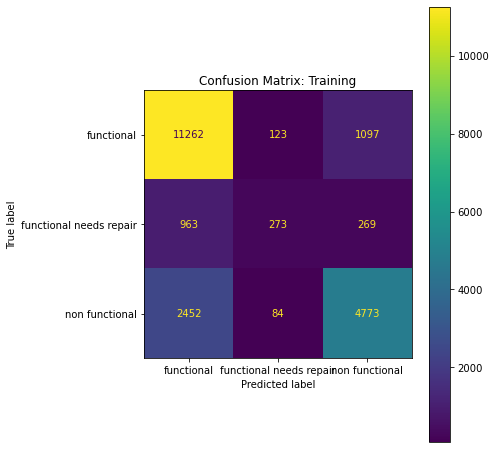

In [16]:
fix, ax = plt.subplots(figsize=(6, 8))
plot_confusion_matrix(pipe_2, X_train, y_train, ax=ax)
ax.set_title('Confusion Matrix: Training')
plt.show()

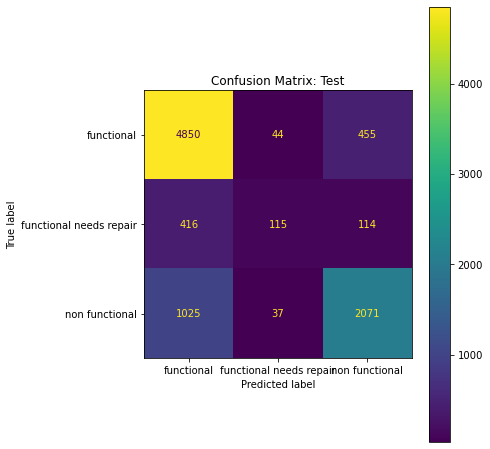

In [17]:
fix, ax = plt.subplots(figsize=(6, 8))
plot_confusion_matrix(pipe_2, X_test, y_test, ax=ax)
ax.set_title('Confusion Matrix: Test')
plt.show()

**Observations:**
Visually, the model appears to perform best on the *functional* class and worse on the *functional needs repair* class. Intuitively this makes sense since *functional* has the largest class membership, while *functional needs repair* has the lowest class membership.

### Classification Report
Metrics for each class predicted by the model can be determined by using ``

In [18]:
y_pred_train_2 = pipe_2.predict(X_train)
y_pred_2 = pipe_2.predict(X_test)

In [19]:
print(classification_report(y_train, y_pred_train_2))

                         precision    recall  f1-score   support

             functional       0.77      0.90      0.83     12482
functional needs repair       0.57      0.18      0.28      1505
         non functional       0.78      0.65      0.71      7309

               accuracy                           0.77     21296
              macro avg       0.70      0.58      0.60     21296
           weighted avg       0.76      0.77      0.75     21296



In [20]:
print(classification_report(y_test, y_pred_2))

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.83      5349
functional needs repair       0.59      0.18      0.27       645
         non functional       0.78      0.66      0.72      3133

               accuracy                           0.77      9127
              macro avg       0.71      0.58      0.61      9127
           weighted avg       0.76      0.77      0.75      9127



**Observations:**
The model performance on the train and test sets is quite similar. The test set only performs a few hundredths of a point worse across all classification report metrics. Therefore, I can conclude that there is no overfitting.

### Model 2: Overfitting Analysis
I will compare metrics between the test and training data sets to determine if there is any overfitting.
* **Accuracy:**
    * The difference in accuracy between the training and test sets was less than 2%.
* **Precision:**
    * _functional_:
        * The precision is identical.
    * _functional needs repair_:
        * There is a difference of 0.02 between the test and training sets.
    * _non functional_:
        * The precision is identical.
* **Recall:**
    * _functional_:
        * There is a difference of 0.01 between the test and training sets.
    * _functional needs repair_:
        * The recall is identical.
    * _non functional_:
        * There is a difference of 0.01 between the test and training sets.
        
The closeness in metrics values between the test and training sets indicates that overfitting is not an issue for a logistic regression problem. Therefore, I do not need to consider regularization.

### Model 2: Feature Importance
I will now explore feature importance. But, first I need to understand the coefficients for this model.

In [21]:
multi_class_param = pipe_2.get_params()['log_reg__multi_class']
print(f'The multi_class param is {multi_class_param}.')

The multi_class param is auto.


According to the sklearn documentation, if multi_class is set to 'auto' and the number of classes is greater than two, the model defaults to a multi_class value of 'multi_nominal'. The means that for each sample prediction a separate probability is computed for each class. The class with the highest probability is then assigned as the predicted class for that sample.

Now, I will explore the shape of the coefficents array.

In [22]:
pipe_2.named_steps['log_reg'].coef_.shape

(3, 230)

The coefficents consist of three columns, one for each class, and 230 rows, the number of features in the dataset.

Let's determine which column index corresponds to which class.

In [23]:
for i, class_name in enumerate(pipe_2.named_steps['log_reg'].classes_):
    print(f" * '{class_name}' class corresponds to index {i}.")

 * 'functional' class corresponds to index 0.
 * 'functional needs repair' class corresponds to index 1.
 * 'non functional' class corresponds to index 2.


Now, I will determine the important features for each class in the target variable, as determined by the model.

In [24]:
def gather_feature_importance(X, model, step_name, top_n_features=10):
    feature_importance_dict = {}
    for i in range(len(model.named_steps[step_name].coef_)):
        feature_importance = pd.DataFrame({'features': X.columns.to_list(), 'coefs': model.named_steps[step_name].coef_[i]})
        feature_importance['abs_coefs'] = np.abs(feature_importance['coefs'])
        feature_importance = feature_importance.sort_values(by='abs_coefs', ascending=False).iloc[:top_n_features, :]
        feature_importance_dict[model.named_steps[step_name].classes_[i]] = feature_importance
    return feature_importance_dict

In [25]:
feature_importance_dict = gather_feature_importance(X, pipe_2, 'log_reg')

In [26]:
for class_name, feature_importance in feature_importance_dict.items():
    print(f'Class Name: {class_name}')
    display(feature_importance)
    print('')

Class Name: functional


,features,coefs,abs_coefs
214,quantity_group_enough,2.303787,2.303787
216,quantity_group_seasonal,2.017351,2.017351
215,quantity_group_insufficient,2.015790,2.015790
217,quantity_group_unknown,1.917943,1.917943
229,waterpoint_type_other,-1.433777,1.433777
40,lga_Karatu,1.240304,1.240304
1,longitude,1.168960,1.168960
122,construction_year_1961,-1.161654,1.161654
57,lga_Liwale,1.028770,1.028770
39,lga_Iringa Rural,0.967861,0.967861



Class Name: functional needs repair


,features,coefs,abs_coefs
63,lga_Masasi,1.466770,1.466770
34,lga_Hanang,-1.383029,1.383029
28,lga_Arusha Urban,1.376605,1.376605
105,lga_Tunduru,1.376169,1.376169
71,lga_Moshi Rural,1.165637,1.165637
25,region_Shinyanga,1.145857,1.145857
31,lga_Bariadi,1.145857,1.145857
53,lga_Kiteto,1.141463,1.141463
40,lga_Karatu,-1.138358,1.138358
215,quantity_group_insufficient,1.122645,1.122645



Class Name: non functional


,features,coefs,abs_coefs
214,quantity_group_enough,-3.394977,3.394977
215,quantity_group_insufficient,-3.138435,3.138435
216,quantity_group_seasonal,-3.062587,3.062587
217,quantity_group_unknown,-2.365518,2.365518
71,lga_Moshi Rural,-1.747528,1.747528
63,lga_Masasi,-1.496800,1.496800
28,lga_Arusha Urban,-1.481037,1.481037
95,lga_Singida Rural,-1.121490,1.121490
130,construction_year_1969,1.107868,1.107868
24,region_Ruvuma,-0.995250,0.995250


**Observations:**
* Class: functional
    * The feature contributing most positively is *quantity_group_enough*.
    * The feature contributing most negatively is *waterpoint_type_other*.
* Class: functional needs repair
    * The feature contributing most positively is *lga_Arusha Urban*.
    * The feature contributing most negatively is *lga_Hanang*.
* Class: non functional
    * There is not dominant, positive feature.
    * The feature contributing most negatively is *quantity_group_enough*.
    
The amount of water at a pump appears to be strongly related to whether the pump is functional or not.

### Model 3: Logistic Regression - One-vs-Rest
I would like to create an ROC curve as an additional way to assess the model fit. But, ROC curves only work with binary classification problems. Since this is a multi-class classification problem, I will need to change my strategy.

What I can do is create a model that fits each class to the additional two classes. This would create three binary classification problems. I can then create and ROC curve for each class and compare them.

In [27]:
estimators_3 = [('min_max', MinMaxScaler()), ('log_reg', LogisticRegression(multi_class='ovr', solver='liblinear'))]
pipe_3 = Pipeline(estimators_3)
pipe_3.fit(X_train, y_train)
print(f'The training score is: {pipe_3.score(X_train, y_train):0.3%}.')
print(f'The test score is: {pipe_3.score(X_test, y_test):0.3%}.')

The training score is: 76.568%.
The test score is: 77.112%.


In [28]:
y_pred_train_3 = pipe_3.predict(X_train)
y_pred_3 = pipe_3.predict(X_test)

In [29]:
print(classification_report(y_train, y_pred_train_3))

                         precision    recall  f1-score   support

             functional       0.76      0.91      0.83     12482
functional needs repair       0.63      0.15      0.24      1505
         non functional       0.78      0.65      0.71      7309

               accuracy                           0.77     21296
              macro avg       0.72      0.57      0.59     21296
           weighted avg       0.76      0.77      0.75     21296



In [30]:
print(classification_report(y_test, y_pred_3))

                         precision    recall  f1-score   support

             functional       0.77      0.91      0.83      5349
functional needs repair       0.63      0.15      0.24       645
         non functional       0.79      0.66      0.72      3133

               accuracy                           0.77      9127
              macro avg       0.73      0.57      0.60      9127
           weighted avg       0.76      0.77      0.75      9127



In [31]:
y_train_proba_3 = pipe_3.fit(X_train, y_train).predict_proba(X_train)
y_test_proba_3 = pipe_3.fit(X_train, y_train).predict_proba(X_test)

In [32]:
y_train_oh = pd.get_dummies(pd.Series(y_train)).values
y_test_oh = pd.get_dummies(pd.Series(y_test)).values

In [33]:
class_names = pd.get_dummies(pd.Series(y_train)).columns.to_list()

In [34]:
def gather_roc_info(y_oh, y_proba):
    fpr = {}
    tpr = {}
    num_classes = y_oh.shape[1]
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_oh[:, i], y_proba[:, i])
    return fpr, tpr

In [35]:
def compute_auc(y_oh, y_proba):
    auc_dict = {}
    num_classes = y_oh.shape[1]
    fpr, tpr = gather_roc_info(y_oh, y_proba)
    for i in range(num_classes):
        auc_dict[i] = auc(fpr[i], tpr[i])
    return auc_dict

In [36]:
def plot_roc(y_oh, y_proba, class_names, dataset_type=None, figure_name=None):
    fpr, tpr = gather_roc_info(y_oh, y_proba)
    auc_dict = compute_auc(y_oh, y_proba)
    num_classes = y_oh.shape[1]
    fig, ax = plt.subplots(figsize=(6, 6))
    title_value = 'ROC'
    if dataset_type is not None:
        title_value += f' for {dataset_type.title()} Set'
    for i in range(num_classes):
        ax.plot(fpr[i], tpr[i], label=f'{class_names[i]} [AUC = {auc_dict[i]:0.3f}]')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
    ax.plot([0, 1], [0, 1], color='black')
    ax.set_title(title_value)
    if figure_name is not None:
        plt.savefig(f'../reports/images/{figure_name}.png')
    else:
        pass
    plt.show()

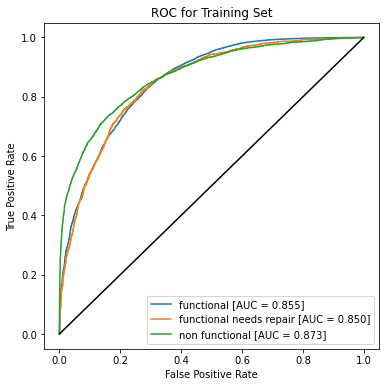

In [39]:
plot_roc(y_train_oh, y_train_proba_3, class_names, dataset_type='training', figure_name='roc_train')

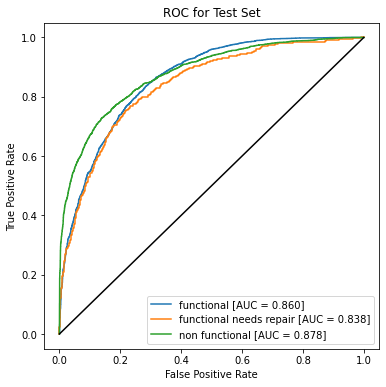

In [40]:
plot_roc(y_test_oh, y_test_proba_3, class_names, dataset_type='test', figure_name='roc_test')

**Observations:**
The above plots show the ROC for the training and test sets, separated by the target class. The classes _functional_ and _functional needs repair_ follow similar trends, while _non functional_ has a steeper incline in true positive rate. All AUC values are high, ranging between 0.83 and 0.88. The class _non functional_ has the highest AUC, 0.878. I can conclude that a logistic regression model does a reasonable job of fitting the dataset. 

### Save train and test sets

In [39]:
data_sets = [X_train, X_test, y_train, y_test, y_pred_3]
filenames = ['X_train', 'X_test', 'y_train', 'y_test', 'y_pred_base']
for i, filename in enumerate(filenames):
    outfile = open(f'../data/clean/{filename}', 'wb')
    pickle.dump(data_sets[i], outfile)
    outfile.close()

## Summary
During pre-processing, I have determined the following items:
* I created a preliminary logistic regression model with an accuracy of 77% on the training set and 76% on the test.
* The classification metrics for the training and test sets are similar, differing by no more than 0.02, with a fit on the test set that is slightly worse.
* The similarity in metrics between the training and test sets indicates that over fitting is not a problem.
* An analysis of feature importance indicates that the amount of water at a pump appears to be strongly related to whether the pump is functional or not.
* An ROC plot for each class show similar profiles. All AUC values for each class range between 0.83 and 0.88.

## Conclusions
I have shown that a logistic regression model can serve as a good baseline for predicting water quality. Considering an accuracy of 76%, there is room for improvement.

When considering each class separately in a one-vs-rest model, the similarities in ROC curves and AUC values across each class indicates that this logistic regression model does a good model fit for each class. But, when fitting a multinominal model, when all three classes are considered together, there is a low recall value for the minority class, _functional needs repair_. During the modeling phase, I will consider this class imbalance issue in more detail.

After speaking with the client, I have been requested to optimize the recall metric in the final model. Recall will need to be at least 0.95 across all classes for the model to be accepted. I will accomplish this by the following methods:
* Investigate miss-classification errors for the class with the lowest recall.
    * Are there any patterns in samples that have been miss-classified?
* Explore features in more detail.
    * Are there any irrelavent features that could be removed?